## Epidemiological SEIR model

In compartmental modeling in epidemology, SEIR (Susepttible, Exposed, Infectious, Recovered) is a simplified set of equations to model how an infectious dissease spreads through a population. 
See for example [the Wikipedia article](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) for more information.

The form we consider here, the model consists of a system of four non-linear differential equations:

\begin{align*}
\tfrac{\mathrm{d}S}{\mathrm{d}t} &= - \beta IS \tag{% Susceptible} \\
\tfrac{\mathrm{d}E}{\mathrm{d}t} &= \beta IS - \alpha E  \tag{% Exposed} \\
\tfrac{\mathrm{d}I}{\mathrm{d}t} &= -\gamma I + \alpha E \tag{% Infectious} \\
\tfrac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I \tag{% Recovered}
\end{align*}

where $S(t)$, $E(t)$, $I(t)$ and $R(t)$ are stochastic processes varying in time.
The model has three model parameters: $\alpha$, $\beta$ and $\gamma$, which determine how fast the disease spreads through the population and are different for every infectious disease, so they have to be estimated.

We can implement the relationship of these ordernary equations in terms of Python code:

In [1]:
def ode_seir(variables, coordinates, parameters):
    var_s, var_e, var_i, var_r = variables
    alpha, beta, gamma = parameters
    
    delta_s = -beta*var_i*var_s
    delta_e = beta*var_i*var_s-alpha*var_e
    delta_i = -gamma*var_i+alpha*var_e
    delta_r = gamma*var_i
    
    return delta_s, delta_e, delta_i, delta_r

### Initial condition

The initial condition $(S(0), E(0), I(0), R(0)) = (1-\delta, \delta, 0, 0)$ for some small $\delta$. Note that the state $(1,0,0,0)$ implies that nobody has been exposed, so we must assume $\delta>0$ to let the model to actually model spread of the dissaese. Or in terms of code:

In [2]:
def initial_condition(delta):
    return 1-delta, delta, 0, 0

### Model parameters

The model parameters $\alpha$, $\beta$ and $\gamma$ are assumed to have a value, but are in all practical applications unknown. Because of this, it make more sense to assume that the parameters are inherently uncertain and can only be described through a probability distribution. For this example, we will assume that all parameters are uniformly distributed with 

\begin{align*}
\alpha &\sim \mathcal{U}(0.15, 0.25) & \beta &\sim \mathcal{U}(0.95, 1.05) & \gamma &\sim \mathcal{U}(0.45, 0.55)
\end{align*}

Or using `chaospy`:

In [3]:
import chaospy

alpha = chaospy.Uniform(0.15, 0.25)
beta = chaospy.Uniform(0.95, 1.05)
gamma = chaospy.Uniform(0.45, 0.55)
distribution = chaospy.J(alpha, beta, gamma)

### Deterministic model

To have a base line of how this model works, we will first assume the uncertain parameters have some fixed value.
For example the expected value of the uncertain parameters:

In [4]:
parameters = chaospy.E(distribution)
parameters

array([0.2, 1. , 0.5])

We then solve the SEIR model on the time interval $[0, 200]$ using $1000$ steps using `scipy.integrate`:

In [5]:
import numpy
from scipy.integrate import odeint

time_span = numpy.linspace(0, 200, 1000)
responses = odeint(ode_seir, initial_condition(delta=1e-4), time_span, args=(parameters,))

We then use `matplotlib` to plot the four processes:

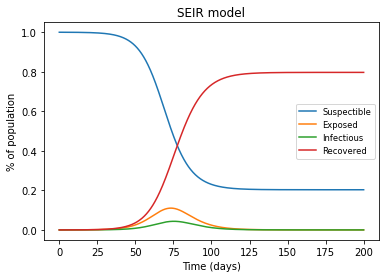

In [6]:
from matplotlib import pyplot

labels = ['Suspectible', 'Exposed', 'Infectious', 'Recovered']
for response, label in zip(responses.T, labels):
    pyplot.plot(time_span, response, label=label)

pyplot.title('SEIR model')
pyplot.xlabel('Time (days)')
pyplot.ylabel('% of population')
pyplot.legend()

### Stochastic model

We now have our deterministic base line model, and can observe that it works. 
Let us change the assumption to assume that the parameters are random, and model it using polynomial chaos expansion (PCE).

We start by generating a PCE bases:

In [7]:
polynomial_order = 3
polynomial_expansion = chaospy.generate_expansion(
    polynomial_order, distribution)
polynomial_expansion[:5].round(5)

polynomial([1.0, q2-0.5, q1-1.0, q0-0.2, q2**2-q2+0.24917])

Generate our quadrature nodes and weights:

In [8]:
quadrature_order = 8
abscissas, weights = chaospy.generate_quadrature(
    quadrature_order, distribution, rule="gaussian")

We wrap the deterministic model solution into a function of the model parameters:

In [9]:
def model_solver(parameters, delta=1e-4):
    return odeint(ode_seir, initial_condition(delta), time_span, args=(parameters,))

Now we're going to evaluate the model taking parameters from the quadrature. To reduce the computational load, we use multiprocessing to increase the computational speed.

In [10]:
from multiprocessing import Pool

with Pool(4) as pool:
    evaluations = pool.map(model_solver, abscissas.T)

And finally we're calculating the PCE Fourier coefficients:

In [11]:
model_approx = chaospy.fit_quadrature(
    polynomial_expansion, abscissas, weights, evaluations)

With a model approximation we can calculate the mean and the standard deviations:

In [12]:
expected = chaospy.E(model_approx, distribution)
std = chaospy.Std(model_approx, distribution)

Finally we can plot the data with uncertainty intervals:

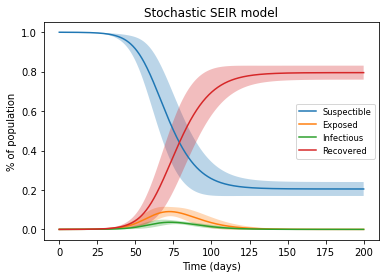

In [13]:
for mu, sigma, label in zip(expected.T, std.T, labels):
    pyplot.fill_between(
        time_span, mu-sigma, mu+sigma, alpha=0.3)
    pyplot.plot(time_span, mu, label=label)
    
pyplot.xlabel("Time (days)")
pyplot.ylabel("% of population")
pyplot.title('Stochastic SEIR model')
pyplot.legend()